<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:12<00:00, 13351684.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
train_loader = DataLoader(training_data, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

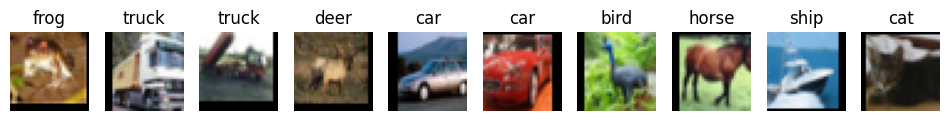

In [7]:

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()


In [8]:
#Creating a class that instantiate a CNN module:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels = 64, kernel_size =3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size =3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels = 256, kernel_size =3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,  padding =1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding =0)
    self.fc1 = nn.Linear(512*2*2, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)
    self.relu = nn.ReLU()
    # self.dropout = nn.Dropout(0.5)


  def forward(self, X):
    X = self.pool(F.relu(self.conv1(X)))
    X = self.pool(F.relu(self.conv2(X)))
    X = self.pool(F.relu(self.conv3(X)))
    X = self.pool(F.relu(self.conv4(X)))
    X = torch.flatten(X, 1)
    X = F.relu(self.fc1(X))
    # X = self.dropout(X)
    X = F.relu(self.fc2(X))
    X = self.fc3(X)



    return F.log_softmax(X, dim=1)





In [9]:
torch.manual_seed(42)
model = CNN()

In [10]:
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [11]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
import time

start_time = time.time()
#Create variables to track things

epochs = 20
train_losses =[]
test_losses = []
train_accuracies =[]
test_accuracies = []

for epoch in range(epochs):
  model.train()
  running_loss, correct, total =0.0,0,0
  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_losses.append(running_loss/len(train_loader))
  train_accuracies.append(100*correct/total)


  model.eval()
  running_loss, correct, total = 0.0,0,0
  with torch.no_grad():
    for images, labels in test_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss +=loss.item()
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted ==labels).sum().item()
  test_losses.append(running_loss/len(test_loader))
  test_accuracies.append(100*correct/total)

  print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Val Acc: {test_accuracies[-1]:.2f}')


current_time = time.time()

total = current_time - start_time

print(f'Training Time: {total/60} Minutes')

Epoch [1/20], Train Loss: 1.5897, Test Loss: 1.3048, Train Acc: 41.13, Val Acc: 52.27
Epoch [2/20], Train Loss: 1.1802, Test Loss: 1.0675, Train Acc: 57.14, Val Acc: 60.66
Epoch [3/20], Train Loss: 0.9836, Test Loss: 0.9644, Train Acc: 65.04, Val Acc: 66.25
Epoch [4/20], Train Loss: 0.8449, Test Loss: 0.8558, Train Acc: 70.26, Val Acc: 69.51
Epoch [5/20], Train Loss: 0.7660, Test Loss: 0.7807, Train Acc: 73.15, Val Acc: 72.42
Epoch [6/20], Train Loss: 0.7006, Test Loss: 0.7069, Train Acc: 75.38, Val Acc: 75.11
Epoch [7/20], Train Loss: 0.6516, Test Loss: 0.7019, Train Acc: 77.33, Val Acc: 75.70
Epoch [8/20], Train Loss: 0.6086, Test Loss: 0.6972, Train Acc: 78.72, Val Acc: 75.72
Epoch [9/20], Train Loss: 0.5760, Test Loss: 0.6659, Train Acc: 80.08, Val Acc: 76.58
Epoch [10/20], Train Loss: 0.5489, Test Loss: 0.6227, Train Acc: 80.83, Val Acc: 78.43
Epoch [11/20], Train Loss: 0.5240, Test Loss: 0.6534, Train Acc: 81.62, Val Acc: 77.83
Epoch [12/20], Train Loss: 0.4988, Test Loss: 0.6186

In [27]:
#Batch 64
#epochs = 20, lr =0.001 came around 81% accuracy.
#epochs = 50, lr=0.001 came around   accuracy.
#epcochs = 20, lr=0.0001 came around 75.93% accuracy.
#epochs =20, lr =0.0005 came around 81.53% accuracy.
#epochs =20, lr =0.0005 came around 81.01% accuracy with dropout 0.5

#Batch 128

#epochs =20, lr =0.0005 came around 80.22% accuracy.
#epochs =20, lr =0.0001 came around 80.79% accuracy.
